In [1]:
import rasterio
from pathlib import Path

from rasterio.plot import show
from rasterio import features
from shapely.geometry import Polygon, MultiPolygon
from rasterio.warp import calculate_default_transform

import numpy as np

from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from shapely.ops import unary_union
import random

In [2]:
df = pd.read_csv("../data/validation_table.csv")
planet_ids = list(df.planet_id)

In [3]:
dswx_parent_path = Path("../data/")
val_parent_path = Path("../data/planet_images_cropped/")

In [4]:
planet_id = random.choice(planet_ids)

dswx_file = list((dswx_parent_path/planet_id).glob("*OPERA*B01*.tif"))[0]
orig_val = list((val_parent_path/planet_id).glob(f"classification_*{planet_id}*.tif"))[0]
expanded_val = list((val_parent_path/planet_id).glob(f"full_img_rf_classification_classification_*.tif"))[0]

In [5]:
# create a dataframe with the geometry of the validation data
with rasterio.open(orig_val) as ds:
    crs = ds.crs
    mask = ds.read(1) != ds.profile['nodata']
    transform = ds.transform

shapes = features.shapes(mask.astype(np.uint8), mask=mask, transform=transform)
val_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')

# create a dataframe with the geometry of the rf output
with rasterio.open(expanded_val) as ds:
    crs = ds.crs
    mask = ds.read(1) != ds.profile['nodata']
    transform = ds.transform

shapes = features.shapes(mask.astype(np.uint8), mask=mask, transform=transform)
exp_val_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')

# create a dataframe with the geometry of the DSWx tile
with rasterio.open(dswx_file) as ds:
    crs = ds.crs
    dswx_img = ds.read(1)
    transform = ds.transform
    dswx_profile = ds.profile

shapes = features.shapes((dswx_img != dswx_profile['nodata']).astype(np.uint8), mask=dswx_img<255, transform=transform)
dswx_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')

In [6]:
intersection_gdf = gpd.GeoDataFrame(geometry=[dswx_gdf.iloc[0].geometry.intersection(exp_val_gdf.iloc[0].geometry)], crs='epsg:4326')

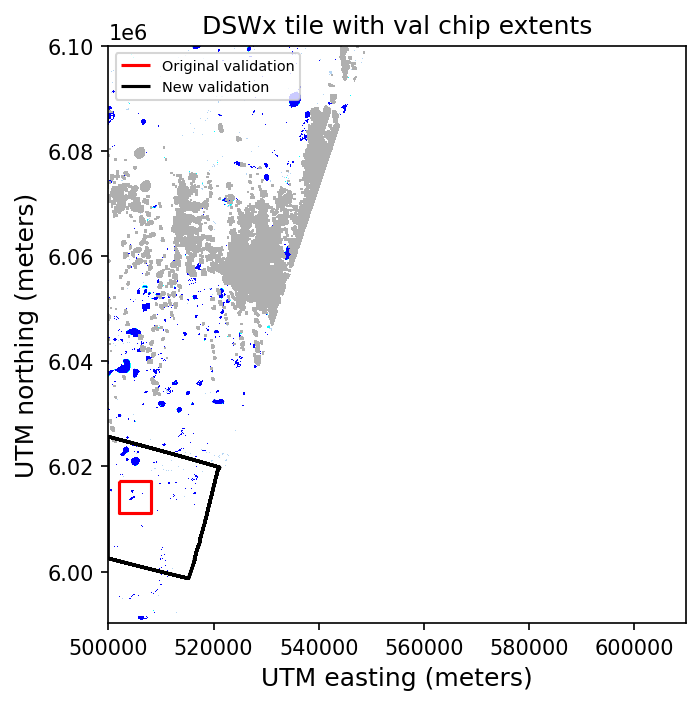

In [7]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5, 5))

with rasterio.open(dswx_file) as ds:
    dswx_img = ds.read(1)
    dswx_crs = ds.crs
    colormap = ds.colormap(1)
    cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
    show(ds, interpolation='none',cmap=cmap,vmin=0,vmax=255,ax=ax)

handle1 = val_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='red')
handle2 = intersection_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='black')

ax.set_title('DSWx tile with val chip extents', fontsize=12)
ax.set_xlabel('UTM easting (meters)',fontsize=12)
ax.set_ylabel('UTM northing (meters)',fontsize=12)
ax.legend(['Original validation', 'New validation'], loc='upper left', fontsize='x-small')

Text(570.5749375538012, 0.5, 'UTM northing (meters)')

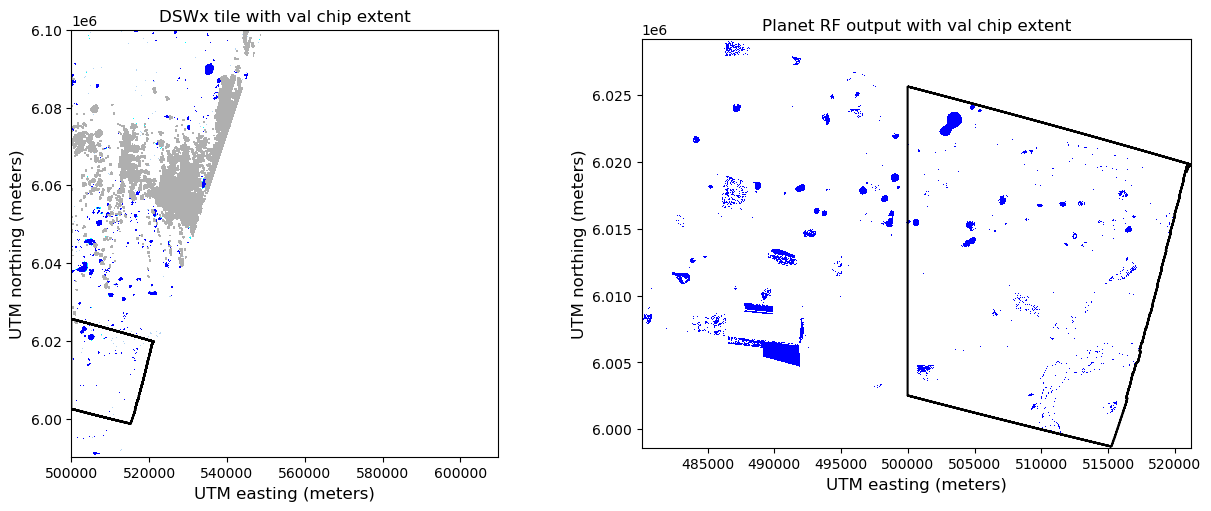

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout='constrained')

with rasterio.open(dswx_file) as ds:
    test_transform = ds.transform
    dswx_crs = ds.crs
    colormap = ds.colormap(1)
    cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
    show(ds, interpolation='none',cmap=cmap,vmin=0,vmax=255,ax=ax[0])

with rasterio.open(expanded_val) as ds:
    val_data = ds.read(1)
    val_crs = ds.crs
    val_profile = ds.profile
    default_transform, nw, nh = calculate_default_transform(val_crs, dswx_crs, ds.profile['width'], ds.profile['height'], *ds.bounds)
    show(val_data, cmap=cmap, transform=default_transform, ax=ax[1], interpolation='none')

# handle1 = val_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='red')
# handle2 = intersection_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='black')

ax[0].set_title('DSWx tile with val chip extent', fontsize=12)
ax[0].set_xlabel('UTM easting (meters)',fontsize=12)
ax[0].set_ylabel('UTM northing (meters)',fontsize=12)
# ax.legend(['Original validation', 'New validation'], loc='upper left', fontsize='x-small')
intersection_gdf.to_crs(dswx_crs).boundary.plot(ax=ax[0], color='black')
intersection_gdf.to_crs(dswx_crs).boundary.plot(ax=ax[1], color='black')

ax[1].set_title('Planet RF output with val chip extent', fontsize=12)
ax[1].set_xlabel('UTM easting (meters)',fontsize=12)
ax[1].set_ylabel('UTM northing (meters)',fontsize=12)